# Simulation d'une source constante sauf une année

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [3]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [4]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

In [5]:
from pathlib import Path

# Directory for outputs

path = Path("../../../hess_results/GC_variability_0.18.2/hap-fr")
path.mkdir(exist_ok=True)

pathma = Path(path/"mapdatasets")
pathma.mkdir(exist_ok=True)

pathmo = Path(path/"models")
pathmo.mkdir(exist_ok=True)

# for consistency we will use the template using exp cutoff for both the central source and the DE
# but it will generally require that the cutoff of the DE be frozen and set to infinity (lambda = 0)

model_name = pathmo/"models_template_2cutoff.yaml" 

pathres = Path(path/"simu_variable")
pathres.mkdir(exist_ok=True)

# Début de l'analyse (avec mapdatasets déjà écrits)

## Création de la géométrie

In [6]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

## Creating the datasets

In [75]:
datasets_year = Datasets.read(pathma/"datasets_year.yaml")

## Reading the model template

In [84]:
modelGC,modelG09, modeldiff= Models.read(model_name)

In [85]:
# if needed
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["amplitude"].value = 2.12e-12 #2.12

modelGC.parameters["index"].frozen = True
modelGC.parameters["index"].value = 1.77

modelGC.spectral_model.parameters['lambda_'].frozen = True
modelGC.spectral_model.parameters['lambda_'].value = 1/5.4

modeldiff.parameters["amplitude"].frozen = False
modeldiff.parameters["amplitude"].value = 6.09e-12

modeldiff.parameters["index"].frozen = True
modeldiff.parameters["index"].value = 2.24

modeldiff.spectral_model.parameters['lambda_'].frozen = True
modeldiff.spectral_model.parameters['lambda_'].value = 0.0

In [86]:
modelGCnaive, modeldiffnaive = modelGC.copy(), modeldiff.copy()

modelGCnaive.parameters["amplitude"].value = 3e-12
modeldiffnaive.parameters["amplitude"].value = 5e-12

# faire varier les modèles naifs

## Constructing the mask

In [87]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 3*u.deg)

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.75 * u.deg)

mask_fit = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

mask_fit = Map.from_geom(geom, data=mask_fit)

# Ajustement du modèle aux cartes

In [91]:
def fit_dataset(mapdataset):
    
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    print(table)
    
    stat = fit.stat_profile(parameter='amplitude')
    
    #cov = result.parameters.covariance
    
    return table, result, stat# , cov

# Ajustement des données simulées

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/modeling/models/core.py:95: RuntimeWarning: invalid value encountered in sqrt
  par.error = np.sqrt(variance)


   name      value         unit         min        max    frozen   error  
--------- ----------- -------------- ---------- --------- ------ ---------
    index  1.7700e+00                       nan       nan   True 0.000e+00
amplitude  4.6525e-11 cm-2 s-1 TeV-1        nan       nan  False 9.189e-18
reference  1.0000e+00            TeV        nan       nan   True 0.000e+00
  lambda_  1.8519e-01          TeV-1        nan       nan   True 0.000e+00
    alpha  1.0000e+00                       nan       nan   True 0.000e+00
    lon_0  3.5994e+02            deg        nan       nan   True 0.000e+00
    lat_0 -4.0000e-02            deg -9.000e+01 9.000e+01   True 0.000e+00
    index  2.3000e+00                       nan       nan   True 0.000e+00
amplitude -3.4384e-11 cm-2 s-1 TeV-1        nan       nan  False       nan
reference  1.0000e+00            TeV        nan       nan   True 0.000e+00
    lon_0  8.7910e-01            deg        nan       nan   True 0.000e+00
    lat_0  8.9300e-02    

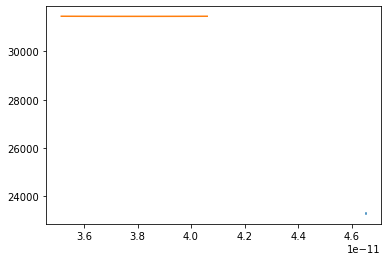

In [92]:
%%time

emin = 1.0*u.TeV
emax = 10*u.TeV

GCflux_distribution = {2004 : [] ,2005 : [] ,2006 : [] ,2007 : [] ,2008 : [] ,2009 : [] ,
                       2010 : [] ,2011 : [] ,2012 : [] ,2013 : [] ,2014 : [] ,2015 : [] ,
                       2016 : [] ,2017 : [] ,2018 : [] ,2019 : []  }
DEflux_distribution = {2004 : [] ,2005 : [] ,2006 : [] ,2007 : [] ,2008 : [] ,2009 : [] ,
                       2010 : [] ,2011 : [] ,2012 : [] ,2013 : [] ,2014 : [] ,2015 : [] ,
                       2016 : [] ,2017 : [] ,2018 : [] ,2019 : []  }
ExcessCounts =        {2004 : [] ,2005 : [] ,2006 : [] ,2007 : [] ,2008 : [] ,2009 : [] ,
                       2010 : [] ,2011 : [] ,2012 : [] ,2013 : [] ,2014 : [] ,2015 : [] ,
                       2016 : [] ,2017 : [] ,2018 : [] ,2019 : []  }

for iter in range(2):
    for year in range(2009,2010):
        # données simulées
        datasets_year[f'map_{year}'].models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy()]
        datasets_year[f'map_{year}'].fake(iter) 
        
        ExcessCounts[year].append(np.sum(datasets_year[f'map_{year}'].excess))
        
        # on remet les modèles
        datasets_year[f'map_{year}'].mask_fit = mask_fit
        bkg_model = FoVBackgroundModel(dataset_name=f"map_{year}")
        
        # partir de différentes valeur pour le fit pour chaque iteration
        modelGCnaive.spectral_model.parameters['amplitude'].value = np.random.normal(4,1)*1e-12
        
        datasets_year[f'map_{year}'].models =  [modelGCnaive.copy(), modelG09.copy(), modeldiffnaive.copy(),bkg_model]

        print(datasets_year[f"map_{year}"].models[0].parameters['amplitude'].value)
        
        # on fait le fit
        table, result, stat = fit_dataset(datasets_year[f"map_{year}"])
        
        print(result)
        
        plt.plot(stat['amplitude_scan'], stat['stat_scan'])
        
        print(datasets_year[f"map_{year}"].models[0].parameters['amplitude'].value)
        print(datasets_year[f"map_{year}"].models[0].parameters['amplitude'].error)
        #print(datasets_year[f"map_{year}"].models[0].parameters['amplitude'].error/datasets_year[f"map_{year}"].models[0].parameters['amplitude'].value)
        
        diffuse_flux = datasets_year[f'map_{year}'].models[2].spectral_model.integral(emin, emax)
        GC_flux = datasets_year[f'map_{year}'].models[0].spectral_model.integral(emin, emax)
        
        GCflux_distribution[year].append(GC_flux)
        DEflux_distribution[year].append(diffuse_flux)

In [46]:
GCflux_distribution

{2004: [],
 2005: [],
 2006: [],
 2007: [],
 2008: [],
 2009: [<Quantity 1.62489777e-12 1 / (cm2 s)>,
  <Quantity 1.62429632e-12 1 / (cm2 s)>],
 2010: [],
 2011: [],
 2012: [],
 2013: [],
 2014: [],
 2015: [],
 2016: [],
 2017: [],
 2018: [],
 2019: []}

In [52]:
stat

{'amplitude_scan': array([1.50888909e-12, 1.68602790e-12, 1.86316671e-12, 2.04030551e-12,
        2.21744432e-12, 2.39458313e-12, 2.57172194e-12, 2.74886075e-12,
        2.92599956e-12, 3.10313837e-12, 3.28027717e-12]),
 'stat_scan': array([30436.46750354, 30434.3949447 , 30432.88585282, 30431.87182797,
        30431.2969388 , 30431.114779  , 30431.28635888, 30431.77855983,
        30432.56297829, 30433.61504585, 30434.91334897]),
 'fit_results': []}

In [59]:
ExcessCounts

{2004: [],
 2005: [],
 2006: [],
 2007: [],
 2008: [],
 2009: [417.3882888692608, 310.3882888692608],
 2010: [],
 2011: [],
 2012: [],
 2013: [],
 2014: [],
 2015: [],
 2016: [],
 2017: [],
 2018: [],
 2019: []}

In [48]:
datasets_year['map_2009'].excess.cutout().plot_interactive()

TypeError: cutout() missing 2 required positional arguments: 'position' and 'width'

In [ ]:
# we automatically exclude the years for which the fit didn't succeed (should be the same for all datasets here)

years = []
for year in range(2004,2020):
    if results[year-2004].message =='Optimization terminated successfully.':
        years.append(year)

# Saving the results

In [ ]:
# for each year we will store the pvalue computed for a constant model, 
# knowing that for this year the intrinsic flux is 10%, 20%, 30%, 50% higher than the others years (effectively constant in terms of intrinsic flux)

pvalue_dict = {2004 : [] ,2005 : [] ,2006 : [] ,2007 : [] ,2008 : [] ,2009 : [] ,
               2010 : [] ,2011 : [] ,2012 : [] ,2013 : [] ,2014 : [] ,2015 : [] ,
               2016 : [] ,2017 : [] ,2018 : [] ,2019 : []  }

In [ ]:
for i in range(4):
    for year in years:
        
        

## Time evolution of the fluxes

In [ ]:
def CalculateFluxFromModels(mapdataset, emin, emax):
    models  = mapdataset.models
    
    amplitudeGC = models[0].spectral_model.parameters['amplitude'].value
    amp_errGC = models[0].spectral_model.parameters['amplitude'].error
    
    amplitudediff = models[2].spectral_model.parameters['amplitude'].value
    amp_errdiff = models[2].spectral_model.parameters['amplitude'].error
    
    #norm = mapdataset.background_model.parameters['norm'].value
    #norm_err = mapdataset.background_model.parameters['norm'].error
    
    if isinstance(emin, u.Quantity):

        diffuse_flux = models[2].spectral_model.integral(emin, emax)
        GC_flux = models[0].spectral_model.integral(emin, emax)
        
    if np.isscalar(emin):
        emin = emin*u.TeV
        emax = emax*u.TeV
        diffuse_flux = models[2].spectral_model.integral(emin, emax)
        GC_flux = models[0].spectral_model.integral(emin, emax)

    return diffuse_flux, GC_flux, amplitudeGC, amp_errGC, amplitudediff, amp_errdiff#, norm, norm_err

In [ ]:
# Extracting parameters from each years fitted model

emin = 1.0*u.TeV
emax = 10*u.TeV
resGC = []
resdiff = []
ampsGC = []
amp_errsGC = []
ampsdiff = []
amp_errsdiff = []
#norms = []
#norms_err = []


for year in years:
    dif , GC, amp, amp_err, ampdiff, amp_errdiff = CalculateFluxFromModels(datasets_year[f"map_{year}"] , emin, emax)
    
    resGC.append(GC.value)
    resdiff.append(dif.value)
    ampsGC.append(amp)
    amp_errsGC.append(amp_err)
    ampsdiff.append(ampdiff)
    amp_errsdiff.append(amp_errdiff)
   
    
    #norms.append(norm)
    #norms_err.append(norm_err)
    
resGC = np.asarray(resGC)
ampsGC = np.asarray(ampsGC)
amp_errsGC = np.asarray(amp_errsGC)
resdiff = np.asarray(resdiff)
ampsdiff = np.asarray(ampsdiff)
amp_errsdiff = np.asarray(amp_errsdiff)
#norms = np.asarray(norms)
#norms_err = np.asarray(norms_err)

In [ ]:
# Errors computation

yerrGC = (resGC/ampsGC)*amp_errsGC
yerrdiff = (resdiff/ampsdiff)*amp_errsdiff

cross_term = []

#cov_per_year n'existe plus ???
#1,8,13,17

for k,year in zip(range(len(years)),years):
    term = 2*(datasets_year[f"map_{year}"].models.covariance.data[1,13]*yerrGC[k]*yerrdiff[k])/(resGC[k]*resdiff[k])
    cross_term.append(term)
      
yerr_rap = (resGC/resdiff)*np.sqrt((yerrGC/resGC)**2 + (yerrdiff/resdiff)**2 - cross_term )

## Fitting a time evolution model

In [ ]:
import scipy.stats as stats

from astropy.modeling import models, fitting

from scipy.stats import chisquare, chi2

# chi2 non réduit
def chisq(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    return chisq

# chi2 réduit
def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr/(len(obs) -1)

def pval(obs, exp, error, nddl): # number of DoF is the number of points minus number of fitted parameters (1 for a constant)
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    pval = 1 - chi2.cdf(chisq, nddl)
    return pval

### Evolution of the ratio

In [ ]:
x = years
y = resGC/resdiff
y_uncs = yerr_rap


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(0.6)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)


A1 = y
A2 = t(2004)
err_bars = yerr_rap

pv = pval(A1, A2, err_bars, len(A1)-1)

error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label=f"constant ratio = {A2:0.2e} ± {error_const:0.1e}, pval = {pv:0.3f}")
plt.xlabel('year')
plt.ylabel('')
plt.legend(loc=1)

plt.title("Fitting of the source/DE ratio")
plt.savefig(pathres/"LC_ratio_1cut_fr.pdf")

## Model predictions

In [ ]:
pathm = Path(pathres/"model_maps")
pathm.mkdir(exist_ok=True)

for year in years:
    plt.figure(figsize=(5,5))
    datasets_year[f"map_{year}"].npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
    plt.title("model prediction (npred) " + str(year))
    
    name ="model_"+ str(year)+"_map_fr.pdf"
    plt.savefig(pathm/name)

## Residuals

In [ ]:
pathr = Path(pathres/"residuals")
pathr.mkdir(exist_ok=True)

kwargs_spatial = {'vmin':-1, 'vmax':1 } # nécessaire ?

kwargs_spectral = {'method':'diff/sqrt(model)', 'region' : CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)}


for year in years:

    datasets_year[f"map_{year}"].plot_residuals(kwargs_spatial=kwargs_spatial, kwargs_spectral=kwargs_spectral)
    name = "residuals_"+str(year)+"_fr_full.pdf"
    plt.title("residuals (diff/sqrt(model)) " + str(year))
    plt.savefig(pathr/name, overwrite=True)

## Significance

In [ ]:
%%time
#très long ?

paths = Path(pathres/"significance")
paths.mkdir(exist_ok=True)

lima_significances = dict()

for year in years:
    plt.figure()

    lima_estimator = ExcessMapEstimator("0.2 deg", selection_optional=[] )
    
    lima_significances[year] = lima_estimator.run(datasets_year[f"map_{year}"])
    
    lima_significances[year]['sqrt_ts'].plot(add_cbar=True)
    name = "significance_"+str(year)+"_fr_full.pdf"
    
    plt.title("Significance map (data v. predictions) "+str(year))
    plt.savefig(paths/name, overwrite=True)

### Significance distributions

In [ ]:
from scipy.stats import norm

pathh = Path(paths/"significance_distrib")
pathh.mkdir(exist_ok=True)

for year in years:
    plt.figure()
    signidata = lima_significances[year]['sqrt_ts'].cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    # on masque la région en bas à droite
    mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    plt.hist(signidata[0,mask].flatten(),30, histtype='step', density=True)
    
    mean,std=norm.fit(signidata[0,mask])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    y2= norm.pdf(x, 0, 1)   
    plt.plot(x, y2 ,label=r'$\mu$ = 0, $\sigma$ = 1')
    
    plt.legend()
    
    name = "significance_hist"+str(year)+"_fr_full.pdf"
    plt.title("Significance distribution on the central (3°,1.5°) "+str(year))
    plt.savefig(pathh/name, overwrite=True)